# About

In this tutorial, we will walk through how to import, label, and export your neurochemical voltammetry data from your local machine. A follow up tutorial will cover importing and exporting data/models from the cloud using Amazon Web Services. 

This tutorial assumes you are familiar with fast voltammetry for neurochemical monitoring, what voltammograms are and how they are structured, what a flow cell is and how training/validation/test data for machine learning models is used. You should also be familiar basic Python and PyData stack (e.g., `scikit-learn`, `pandas`, `numpy`, `matplotlib`).

Here, we will show an example of uploading, analyzing, and exporting *in vitro* flow cell data/models using rapid pulse voltammetry for serotonin (HT) and dopamine (DA) data. Here, we know the concentrations related to each voltammogram. Thus, we must relate each voltammogram to some concentration in order to train a model and make predictions. More information on rapid pulse voltammetry can be found here: https://link.springer.com/article/10.1007/s00216-021-03665-1

First, we will import our needed packages.

If you do not have it already, it is suggested to install Anaconda (https://docs.anaconda.com/). This will provide most the packages we will be using. A couple other packages need to be manually installed: `mat73`, `pca`, `ipynb`.

You can install these in the notebook by running a cell containing `!pip install <package_name>` or by using the Anaconda command prompt to run `conda install <package_name>` (for `mat73`) or `pip install <package_name>` (for `pca` and `ipynb`).

In [19]:
#pandas
import pandas as pd

#scipy
import scipy as sp, numpy as np
import scipy.io as io

#matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#misc
import warnings
import pickle
import mat73

# Formatting Data and File Types

This section assumes you have  a file containing your voltammetry data that you wish to import into a Jupyter notebook. This could be the files provided with this notebook, or your own data. Voltammetry data comes in many file types due to many labs having their own custom-built acquisition software and workflows. As the community grows, hopefully will the supported file types in this notebook. For now, we offer solutions specifically catered to MATLAB users and Excel users, as most voltammetry practicioners should be able to get their data into one of these formats regardless of the raw data form.

Another note on raw data- we will try to avoid background subtraction, averaging, filtering, etc. in order to provide open-data in its most raw form. For example, rapid pulse voltammetry uses non-background-subtracted data. Users of other analyses can background subtract, or perform averaging or filtering as needed, so long as the raw data is provided, but not vice versa. For this reason, we reccomend providing raw and any processed data to the community, with detailed metadata on what exactly has been done to the data.

If you would like to follow along with the data used in this notebook, see the 'demo' folder at https://github.com/csmova/SeroML. Download and rename the file paths on your machine as needed.

## MATLAB

### SeroWare Users

First, we will cover importing data from `.mat` file. Our `.mat` file is made automatically using SeroWare software. For users of SeroWare, the `.mat` files exported from SeroDataProcess module should already have this structure.

A screenshot from the SeroWare data processing module is shown below to demonstrate the structure of the data. In short, various flow cell injections are shown as peak labels (*e.g.*, `0`, `A`, `B`, `C`...). Each of these labels represents a combination of known analytes and concentrations that comprise that sample. The user selects however many voltammograms to extract from each peak to comprise their training set. For brevity, we only extract one voltammogram per sample, but commonly tens to hundreds may be extracted per peak.

For more information, see SeroWare user guide at www.github.com/csmova/seroware/wiki

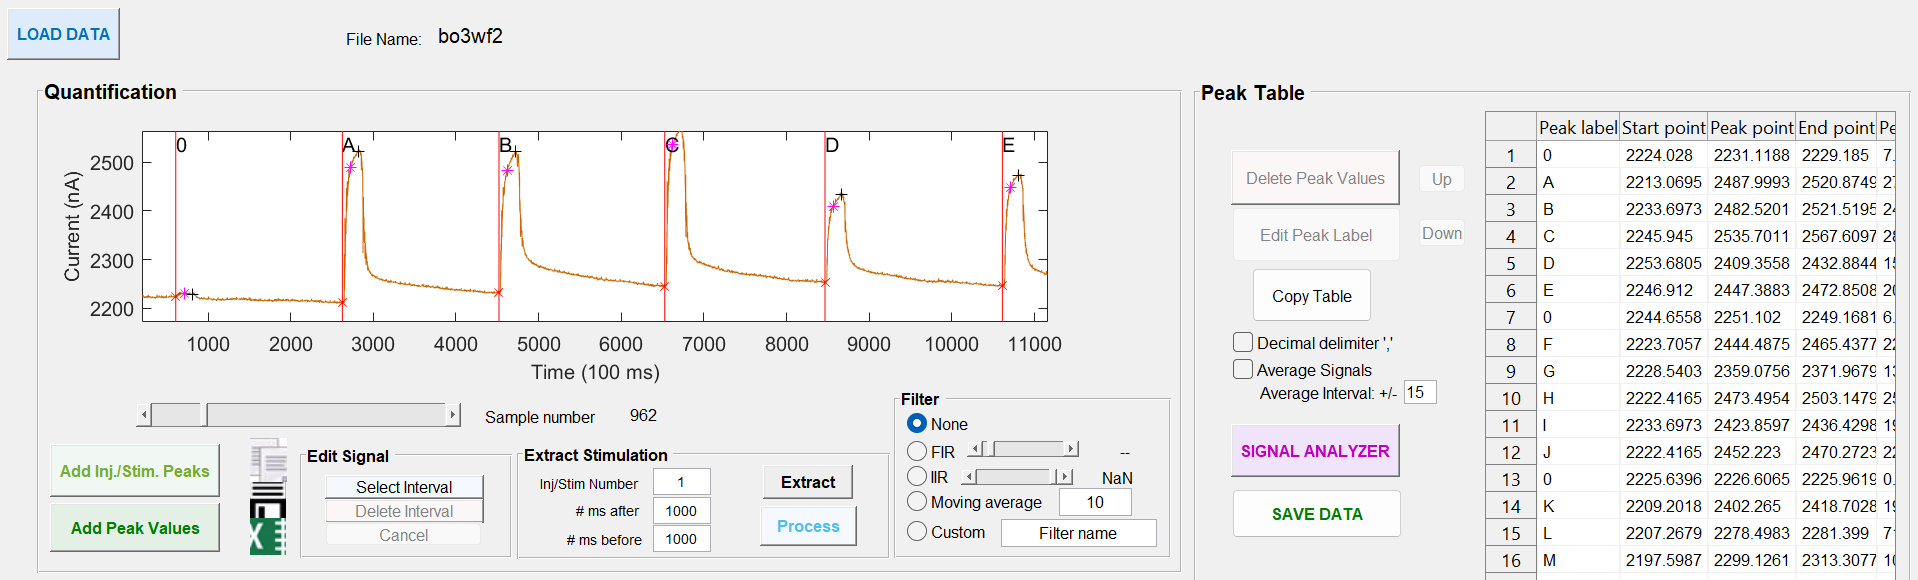

SeroWare users should extract their desired data and make sure all peaks have correct, meaningful labels. The extracted data will have the following output file structure:

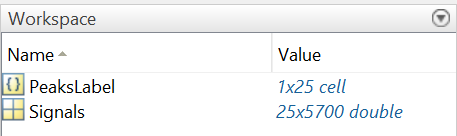

The `PeaksLabel` variable  contains the label of each voltammogram from a given sample, as shown in the SeroWare screenshot (e.g., `0`, `A`, `B`...) (see Peak Table). Note that the shape is 1x25, meaning each column corresponds to one label. In total, we extracted the following:

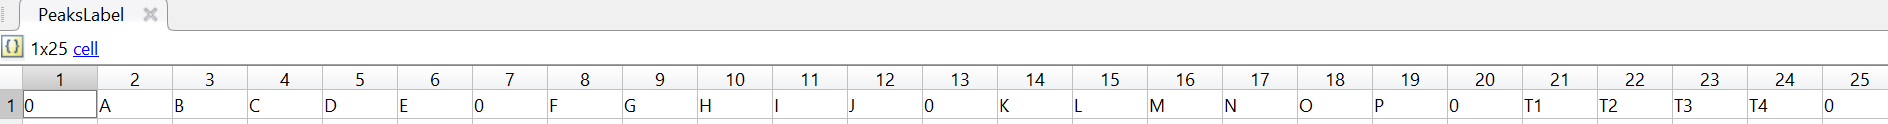

The `Signals` variable contains the voltammograms. Note that its structure is 25x5700. Thus, each row corresponds to a voltammogram, ordered by `PeaksLabel` (e.g., the voltammogram in row 1 corresponds to sample labeled 0, row 2 corresponds to sample A and so on). The number of columns is simply the number of acquired points for that voltammogram. Here, at a sampling speed of 1 MHz with a waveform that is 5.7 ms long, this results in 5700 data points per voltammogram.

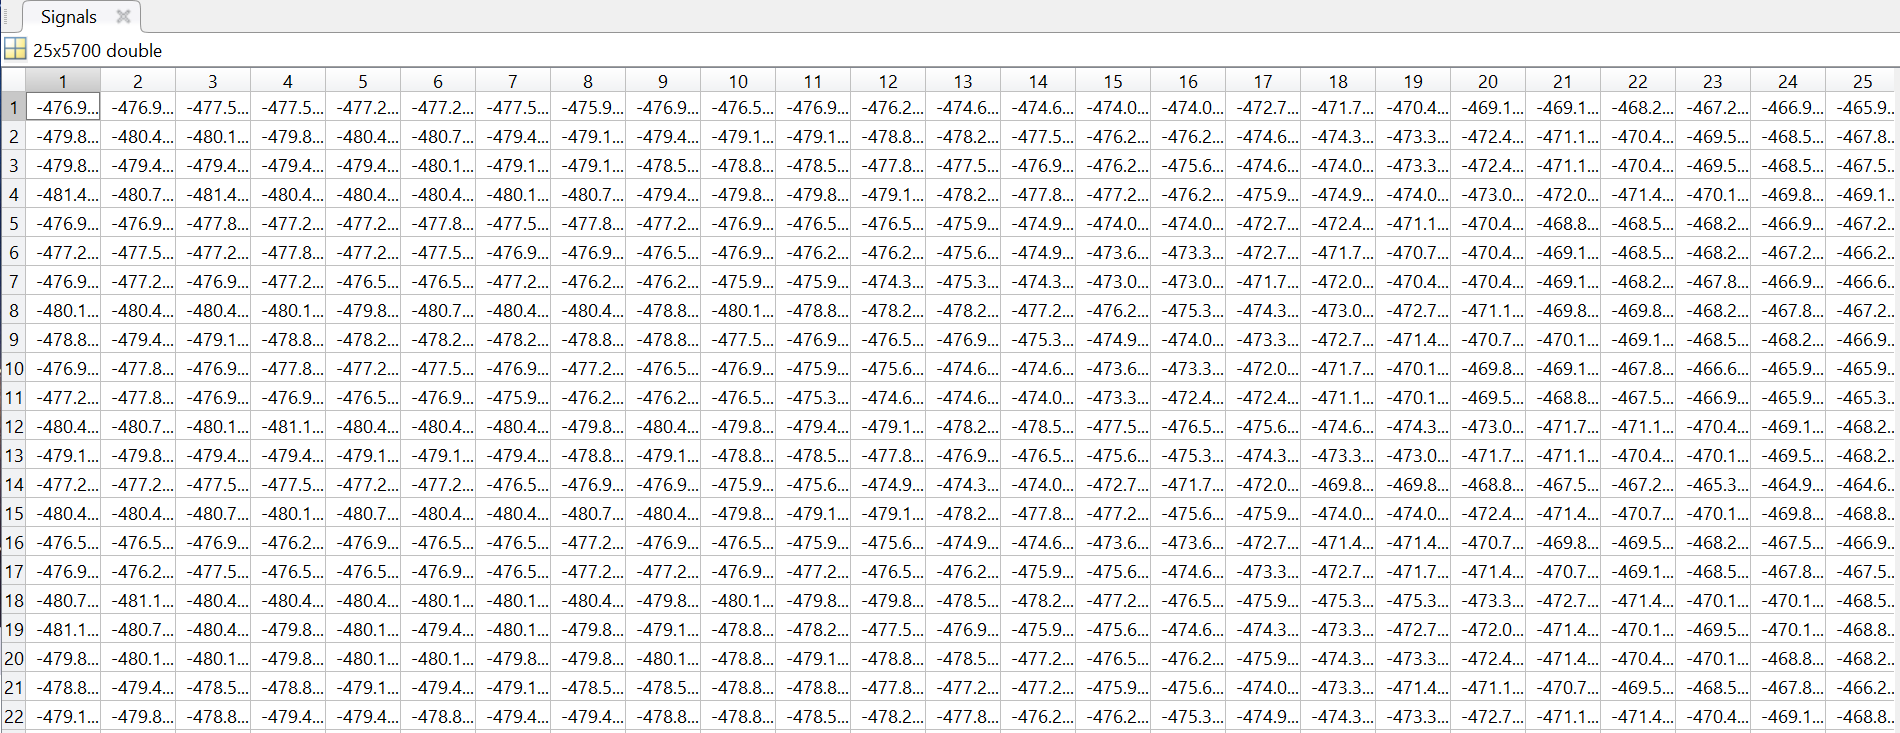

### Non-SeroWare MATLAB Users

If you have a MATLAB (`.mat`) file but are not using SeroWare, simply manipulate your data so that it contains the same structure and names as a above.

* A `Signals` matrix containing all voltammograms, where each column is a single voltammogram. Only include data, do not include any labels or indices.
* A `PeakLabels` vector containing the labels for all such voltammograms, where each column corresponds to a voltammogram.

## Excel and other file types

We also   provide Excel as an option to import data, as this is another common and user-friendly way of formatting an import file. Regardless of acquisition software, most voltammetry users can get their data into an Excel format.

Still, we recommend using `.mat` files, as these import much quicker compared to Excel. Interested users can augment the `import_data`  function (see below) as desired to work with their desired file types, such as .csv or acquisition-software specific file types. Please create issues or pull requests on www.github.com/csmova/serodb if you have a specific file type issue or create a script for a new file type to share with the community.

Simply place all your desired data into a single Excel sheet. The default name is Sheet1.

The below example is the same data from SeroWare in the `.mat` file, except exported as an Excel file. As expected, we have 25 columns, each corresponding to a voltammogram (as plotted), with 5700 rows per column.

The first row of the data should contain your `PeaksLabel`. The column of each row should contain the corresponding voltammogram, as in `Signals`. See below example (the plot was added only for illustration of the data).

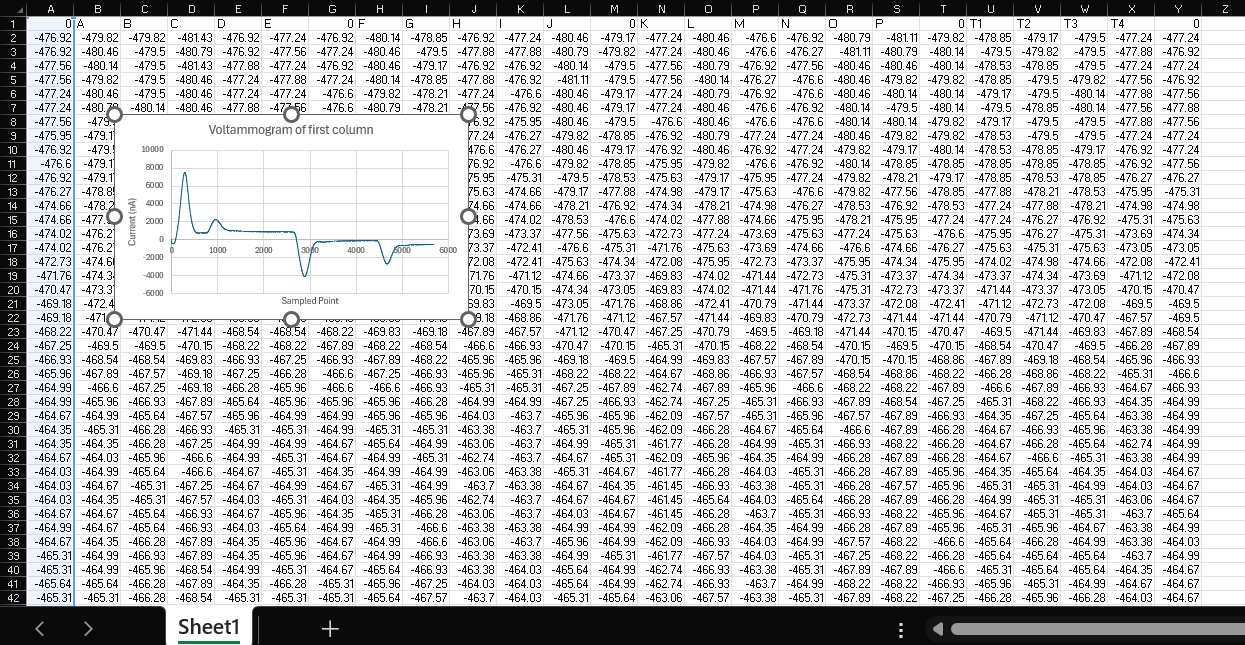

# Importing Data

At this point, we have our data in a standardized file type and format.

Next, we will create some helper functions that will import our data into the notebook and help label it.

In [20]:
def import_data(myFile,analyteList,mySamples='Signals',myConcentrations='PeaksLabel'): 
    """Takes in file location (myFile) and list of desired analytes (analyteList)
    and returns X_train and y_train arrays. Analytes must be named in same manner as data file"""
    
    if myFile[-3:] == 'mat':
        mat1 = mat73.loadmat(myFile) 
        myX = mat1.get('Signals')
        peak_labels = mat1.get('PeaksLabel') 
        myX = pd.DataFrame(myX,index=peak_labels)

        return myX.T, peak_labels
    
    if myFile[-4:] == 'xlsx':
        myData = pd.read_excel(myFile, sheet_name='Sheet1') 
        peak_labels=myData.columns.to_list()
        myX=myData
        
        return myX, peak_labels


Now, define the analytes you wish to label (`analyte_list`) and any plotting color preferences (`cmap`). These color codes will denote how the plots in figures are created later on.

For example, we will label dopamine as DA and color it red, while we will label serotonin as HT and label it blue.

For a list of color codes, see https://matplotlib.org/2.0.2/api/colors_api.html

These analyte labels must match your look up table (schema), defined below!

In [21]:
analyte_list=['DA','HT']
cmap = {'DA':'r','HT':'b'}

Here, we will assume all this data is training data. So, we will label the outputs as `X_train` and `train_labels`.

The file type will be automatically detected as a `.xlsx` or `.mat` file.

Now, you should set the following arguments.

In [22]:
X_train_matlab, train_labels_matlab = import_data("./demo/bo3wf2_e119_pedotnafionCFME_02142024.mat",
                                   analyte_list)

Consider putting useful information in your file names. Here, `bo3wf2` is our waveform name, `e119` corresponds to the length of the electrode tip in micrometers, `PEDOT:Nafion` is a type of polymer coating on the type of electrode used (carbon fiber microelectrode, `CFME`), and `02142024` is the date of analysis. 

If you are replacing the file location `myFile` argument, only replace the part in quotes. The `r` and qoutes are needed.
Now, let's make sure our data made it in the correct format.

In [23]:
X_train_matlab.head #from MATLAB file

<bound method NDFrame.head of                0           A           B           C           D           E  \
0    -476.917958 -479.818734 -479.818734 -481.430276 -476.917958 -477.240266   
1    -476.917958 -480.463351 -479.496425 -480.785659 -476.917958 -477.562575   
2    -477.562575 -480.141042 -479.496425 -481.430276 -477.884883 -477.240266   
3    -477.562575 -479.818734 -479.496425 -480.463351 -477.240266 -477.884883   
4    -477.240266 -480.463351 -479.496425 -480.463351 -477.240266 -477.240266   
...          ...         ...         ...         ...         ...         ...   
5695 -552.338142 -556.528152 -557.172769 -558.784311 -558.139694 -560.718162   
5696 -551.693525 -557.172769 -557.172769 -559.106620 -559.428928 -559.428928   
5697 -552.015833 -556.205843 -556.850460 -558.784311 -559.106620 -560.073545   
5698 -552.015833 -556.528152 -556.528152 -558.784311 -559.106620 -560.395854   
5699 -552.015833 -556.205843 -556.850460 -558.462003 -559.106620 -559.751237   

         

In [24]:
train_labels_matlab #from MATLAB file

['0',
 'A',
 'B',
 'C',
 'D',
 'E',
 '0',
 'F',
 'G',
 'H',
 'I',
 'J',
 '0',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 '0',
 'T1',
 'T2',
 'T3',
 'T4',
 '0']

In [25]:
X_train_excel, train_labels_excel = import_data("./demo/bo3wf2_e119_pedotnafionCFME_02142024.xlsx",
                                   analyte_list);

In [26]:
X_train_excel.head #from Excel file

<bound method NDFrame.head of                0           A           B           C           D           E  \
0    -476.917958 -479.818734 -479.818734 -481.430276 -476.917958 -477.240266   
1    -476.917958 -480.463351 -479.496425 -480.785659 -476.917958 -477.562575   
2    -477.562575 -480.141042 -479.496425 -481.430276 -477.884883 -477.240266   
3    -477.562575 -479.818734 -479.496425 -480.463351 -477.240266 -477.884883   
4    -477.240266 -480.463351 -479.496425 -480.463351 -477.240266 -477.240266   
...          ...         ...         ...         ...         ...         ...   
5695 -552.338142 -556.528152 -557.172769 -558.784311 -558.139694 -560.718162   
5696 -551.693525 -557.172769 -557.172769 -559.106620 -559.428928 -559.428928   
5697 -552.015833 -556.205843 -556.850460 -558.784311 -559.106620 -560.073545   
5698 -552.015833 -556.528152 -556.528152 -558.784311 -559.106620 -560.395854   
5699 -552.015833 -556.205843 -556.850460 -558.462003 -559.106620 -559.751237   

         

In [27]:
train_labels_excel #from Excel file

[0,
 'A',
 'B',
 'C',
 'D',
 'E',
 '0.1',
 'F',
 'G',
 'H',
 'I',
 'J',
 '0.2',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 '0.3',
 'T1',
 'T2',
 'T3',
 'T4',
 '0.4']

Here, we see that samples that are duplicate names are appended with a decimal and a number.

For example, we had multiple blank injections, labeled as `0` originally, that have `0.1`, `0.2`... etc appended. 

We want to keep the original sample names, because these are in fact meant to be duplicate injections. So, let's create a helper function to remove these delimiters.

In [28]:
def remove_delimiter(myData,myDelimiter='.'):
    """given data (myData) as a list or pandas dataframe, 
    return data with delimiter (myDelimiter, default is a period) removed"""
    if isinstance(myData, pd.DataFrame):
        col_no_decimal = myData.columns.str.split(myDelimiter).str[0]
        for i in range(len(myData.columns)):
            col = str(myData.columns[i])
            if myDelimiter in col:
                myData.rename(columns={col:col_no_decimal[i]},inplace=True)
                
    if isinstance(myData, list):
        for i in range(len(myData)):
            if myDelimiter in str(myData[i]):
                myData[i] = str(myData[i]).split('.')[0]
            else:
                myData[i] = str(myData[i])
                

In [29]:
#remove_delimiter(X_train_excel)
remove_delimiter(train_labels_excel)

In [30]:
train_labels_excel

['0',
 'A',
 'B',
 'C',
 'D',
 'E',
 '0',
 'F',
 'G',
 'H',
 'I',
 'J',
 '0',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 '0',
 'T1',
 'T2',
 'T3',
 'T4',
 '0']

In [31]:
X_train_matlab

,0,A,B,C,D,E,0,F,G,H,...,M,N,O,P,0,T1,T2,T3,T4,0
0,-476.917958,-479.818734,-479.818734,-481.430276,-476.917958,-477.240266,-476.917958,-480.141042,-478.851808,-476.917958,...,-476.595649,-476.917958,-480.785659,-481.107968,-479.818734,-478.851808,-479.174117,-479.496425,-477.240266,-477.240266
1,-476.917958,-480.463351,-479.496425,-480.785659,-476.917958,-477.562575,-477.240266,-480.463351,-479.496425,-477.884883,...,-476.595649,-476.273341,-481.107968,-480.785659,-480.141042,-479.496425,-479.818734,-479.496425,-477.884883,-476.917958
2,-477.562575,-480.141042,-479.496425,-481.430276,-477.884883,-477.240266,-476.917958,-480.463351,-479.174117,-476.917958,...,-476.917958,-477.562575,-480.463351,-480.463351,-480.141042,-478.529500,-478.851808,-479.496425,-477.240266,-477.240266
3,-477.562575,-479.818734,-479.496425,-480.463351,-477.240266,-477.884883,-477.240266,-480.141042,-478.851808,-477.884883,...,-476.273341,-476.595649,-480.463351,-479.818734,-479.818734,-478.851808,-479.496425,-479.818734,-477.562575,-476.917958
4,-477.240266,-480.463351,-479.496425,-480.463351,-477.240266,-477.240266,-476.595649,-479.818734,-478.207192,-477.240266,...,-476.917958,-476.595649,-480.463351,-480.141042,-480.141042,-479.174117,-479.496425,-480.141042,-477.884883,-477.562575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,-552.338142,-556.528152,-557.172769,-558.784311,-558.139694,-560.718162,-557.172769,-557.172769,-555.883535,-560.718162,...,-553.627375,-555.561226,-554.916609,-553.627375,-550.726599,-551.371216,-553.305067,-555.238918,-554.271992,-553.627375
5696,-551.693525,-557.172769,-557.172769,-559.106620,-559.428928,-559.428928,-557.495077,-557.817386,-556.205843,-561.685088,...,-553.627375,-555.883535,-554.594301,-553.949684,-550.726599,-551.693525,-553.949684,-555.883535,-554.271992,-553.949684
5697,-552.015833,-556.205843,-556.850460,-558.784311,-559.106620,-560.073545,-557.817386,-557.817386,-555.561226,-561.040471,...,-553.305067,-555.238918,-554.916609,-553.627375,-549.759674,-551.048908,-553.627375,-555.883535,-553.627375,-553.949684
5698,-552.015833,-556.528152,-556.528152,-558.784311,-559.106620,-560.395854,-557.172769,-557.495077,-555.561226,-560.718162,...,-553.627375,-555.238918,-553.949684,-553.949684,-550.404291,-550.726599,-553.627375,-554.916609,-554.271992,-553.627375


In [32]:
X_train_excel

,0,A,B,C,D,E,0.1,F,G,H,...,M,N,O,P,0.3,T1,T2,T3,T4,0.4
0,-476.917958,-479.818734,-479.818734,-481.430276,-476.917958,-477.240266,-476.917958,-480.141042,-478.851808,-476.917958,...,-476.595649,-476.917958,-480.785659,-481.107968,-479.818734,-478.851808,-479.174117,-479.496425,-477.240266,-477.240266
1,-476.917958,-480.463351,-479.496425,-480.785659,-476.917958,-477.562575,-477.240266,-480.463351,-479.496425,-477.884883,...,-476.595649,-476.273341,-481.107968,-480.785659,-480.141042,-479.496425,-479.818734,-479.496425,-477.884883,-476.917958
2,-477.562575,-480.141042,-479.496425,-481.430276,-477.884883,-477.240266,-476.917958,-480.463351,-479.174117,-476.917958,...,-476.917958,-477.562575,-480.463351,-480.463351,-480.141042,-478.529500,-478.851808,-479.496425,-477.240266,-477.240266
3,-477.562575,-479.818734,-479.496425,-480.463351,-477.240266,-477.884883,-477.240266,-480.141042,-478.851808,-477.884883,...,-476.273341,-476.595649,-480.463351,-479.818734,-479.818734,-478.851808,-479.496425,-479.818734,-477.562575,-476.917958
4,-477.240266,-480.463351,-479.496425,-480.463351,-477.240266,-477.240266,-476.595649,-479.818734,-478.207192,-477.240266,...,-476.917958,-476.595649,-480.463351,-480.141042,-480.141042,-479.174117,-479.496425,-480.141042,-477.884883,-477.562575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,-552.338142,-556.528152,-557.172769,-558.784311,-558.139694,-560.718162,-557.172769,-557.172769,-555.883535,-560.718162,...,-553.627375,-555.561226,-554.916609,-553.627375,-550.726599,-551.371216,-553.305067,-555.238918,-554.271992,-553.627375
5696,-551.693525,-557.172769,-557.172769,-559.106620,-559.428928,-559.428928,-557.495077,-557.817386,-556.205843,-561.685088,...,-553.627375,-555.883535,-554.594301,-553.949684,-550.726599,-551.693525,-553.949684,-555.883535,-554.271992,-553.949684
5697,-552.015833,-556.205843,-556.850460,-558.784311,-559.106620,-560.073545,-557.817386,-557.817386,-555.561226,-561.040471,...,-553.305067,-555.238918,-554.916609,-553.627375,-549.759674,-551.048908,-553.627375,-555.883535,-553.627375,-553.949684
5698,-552.015833,-556.528152,-556.528152,-558.784311,-559.106620,-560.395854,-557.172769,-557.495077,-555.561226,-560.718162,...,-553.627375,-555.238918,-553.949684,-553.949684,-550.404291,-550.726599,-553.627375,-554.916609,-554.271992,-553.627375


In [33]:
train_labels_excel == train_labels_matlab

True

Above, we show that both file types end up giving the same data, as expected.

Since its all the same, we'll rename the variables.

In [34]:
train_labels = train_labels_matlab
X_train = X_train_matlab

# Data Labeling

Now we need to map each sample name (`train_label`) to the concentrations of various analytes that were in our calibration curve.

First, we'll need to create a look up table, or schema. For each data set/user, this will be different. So, we will create it in Excel. This way, we can store different calibration curves in different sheets, all saved under a single file. 

See `RPV_standards_schema.xlsx` file in the `demo` folder in this repo if needed.

For example, for the peak labels listed in SeroWare screenshot that we imported as training labels, we have the following schema:

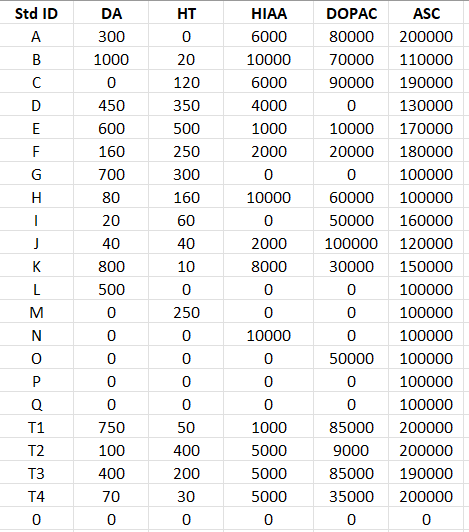

Replace the analytes, sample names/labels (`Std ID`), and concentrations with whatever values you require. Note that here, all concentrations are in nanomolar (nM). Just make sure to keep the `Std ID` column labeled as such. Further, your analytes that you listed in `analyte_list` must match the analyte codes you use here. Note how HT and DA are again used to denote serotonin and dopamine, respectively. Because we do not care about the remaining analytes, we can simply leave them out of `analyte_list`.

When satisfied with your schema, the below helper function imports it from Excel. We recommend keeping all your standard scehmas in a single Excel file, with each sheet representing a different schema. Thus, simply replace the sheet name with your desired schema to upload.

In [35]:
def create_schema_from_excel(schemaFile,schemaSheet):
    """convert excel schema to pandas dataframe"""
    mySchema = pd.read_excel(schemaFile, sheet_name=schemaSheet) 
    mySchema.set_index('Std ID',inplace=True)
    return mySchema

In [36]:
schema = create_schema_from_excel("./demo/RPV_standards_schema.xlsx",
                                  'standardset03302022')

Tip: if you encounter an error denying permission to an Excel file, it is most likely because you have the Excel workbook open on your machine. Simply close the workbook and try again.

With the schema set, we can build another helper function to automatically map each voltammogram/sample name to the correct analyte concentrations. 

In [37]:
def label_concentrations(mySchema,analyteList,myXlabels,fill_null=True):
    """use mySchema as a lookup table for all voltammogram labels (myXlabels) for given analyteList, 
    to build and return a corresponding list of concentrations (myY) for each voltammogram. 
    Empty values are assumed as 0 concentration"""
    myY = pd.DataFrame(columns=analyteList)
    myY['peak_labels'] = myXlabels
    myY.set_index('peak_labels',inplace=True)
    for col in myY.columns:
        myY[col]=myXlabels
    
    for col in myY.columns:
        myY[col]=myY.index.map(mySchema[col])

    if fill_null == True:
        myY.fillna(0,inplace=True) 
        #empty values will be assumed as 0; dangerous if samples are mislabeled!
    
    return myY

In [38]:
y_train = label_concentrations(schema,analyte_list,train_labels)

Now we can print the training labels. Note how there is one voltammogram per sample injected, and the concnetrations are correct according to our schema.

In [39]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(y_train)

                 DA     HT
peak_labels               
0               0.0    0.0
A             300.0    0.0
B            1000.0   20.0
C               0.0  120.0
D             450.0  350.0
E             600.0  500.0
0               0.0    0.0
F             160.0  250.0
G             700.0  300.0
H              80.0  160.0
I              20.0   60.0
J              40.0   40.0
0               0.0    0.0
K             800.0   10.0
L             500.0    0.0
M               0.0  250.0
N               0.0    0.0
O               0.0    0.0
P               0.0    0.0
0               0.0    0.0
T1            750.0   50.0
T2            100.0  400.0
T3            400.0  200.0
T4             70.0   30.0
0               0.0    0.0


# Data Export and Uploading 

Now that our data has been correctly formatted, imported, and labeled, we can continue on and build statisical models or do various types of analysis (see below and next notebook on machine learning models).

Aside from this, we can also save and export our data back out of Python. For example, we can put all this data back into Excel using `pd.DataFrame.to_excel()`, if there are some external tools we wish to use for this data.


We can also upload the data to an open source database for wide community use. The data wrangling tasks we went through above are some of the most time-consuming and least fun tasks. For example, a common number is that ~80% of data scientists time is spent doing some sort of data cleaning. For this reason, we implore you to upload and share your data with the community. There are many options to do so, but as an 'all in one' stop we are trying to build a fast-voltammetry for neurochemicals-specific database called SeroDB. 

This is where Amazon Web Services (AWS) Open Source Registry comes in. See the corresponding notebook. We need users, maintainers, and contributers!

# Next up: Machine Learning Models

With clean, labeled training data in hand, we are ready to perform a variety of machine learning tasks. This is the remaining 20% (modeling, predicting, interpreting, etc...the fun stuff)!

Most commonly, this will be supervised regression. Some common linear models include PCR, PLSR, and elastic net. We will cover these in corresponding notebooks. 

Other models, such as non-linear and deep learning models, are growing in popularity. In the future, we hope to host a variety of template code or pre-trained models for ease of use.

Please consider contributing a tutorial, hosting your code for models or pre-trained parameters with us!

# Food for Thought: how can voltammetry benefit from open data?

Why share voltammetry data, if every lab has a different set up, different goals, different analytes, electrodes, etc.?

For starters, its good practice to ensure reproducible results and aligns with new thrusts in data management and sharing (FAIR principles, NIH DMS policy, etc.).

But beyond this, here are a couple more ideas.
* **Exploring new models and data analyses.** Let's say you have an idea for a new model architecture. It works well for your data from your lab on your analytes. But what if you could easily train and test it on voltammetry data from other labs? You could compare how well your new model architecture generalizes across new waveforms, electrodes, and analytes, simply by training your model on other open data training sets. You could even test your model on real in vivo data, without having to acquire it yourself.
* **Curating inter-lab datasets.** One recent trend in fast voltammetry is combining data across electrodes, often within a single lab. For example, training data from dozens of electrodes is combined with the hopes that a generalizable model can be trained, as the variation across electrodes is taken into account. What if these large training sets could not only be easily shared, but we could also combine training sets across labs that are using the same electrode types, waveforms, and analytes?
* **Meta-analyses.** Are there commonalities between certain electrode types, waveforms, or analytes, when we look across many labs? For example, can we group electrode responses into sub-groups of performance? Are there persistent problems using one type of waveform/electrode/model, perhaps certain interferents/drift/fouling, that are solved using another approach? Is there an underlying reason for this? For example, we can group electrodes by similarity metrics to create 'sub-sets' of training data that are similar to that of the electrode used during testing, to account for out-of-probe variability. Imagine doing this at scale.
* **Facilitate collaboration.** Fast voltammetry is a relatively niche community. We should build eachother up, share code, share what works and doesnt work, and put our heads together to solve the big challenges we all face. Some groups may be really good at electode fabrication, materials, and coatings. Another at doing the in vivo work. And another at the computational level. Imagine bridging all these specialities together, rather than having to do each piece on your own.

There will surely be more ideas of how to mine all this data. And there will surely be issues and problems that arise in curating such a database. But to figure all this out, we first need to build it. This is just one such attempt at creating a common infrastructure.

*Disclaimer: we make no guarantees on the accuracy, functionality or maintenance of any code presented here. Use at your own risk.*